Open issues
- documentation in QM debiaser for.precipitation not up to date

In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [26]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import iris
import math

from scipy.stats import norm, laplace, gamma

from PACKAGE_NAME.variables import Temperature, Precipitation
from PACKAGE_NAME.utils import gen_PrecipitationHurdleModel, gen_PrecipitationGammaLeftCensoredModel

from PACKAGE_NAME.debias import EquidistantCDFMatching, ISIMIP, QuantileMapping, DeltaChange
from PACKAGE_NAME.debias import QuantileDeltaMapping, ScaledDistributionMapping, LinearScaling

from PACKAGE_NAME.evaluate import marginal, EOT, trend, correlation

In [3]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    print(cm)
    
    obs = obs_all[:, :, 0:9000]
    obs_validate = obs_all[:, :, 9001:]
    cm_hist = cm[:, :, 0:9000]
    cm_future = cm[:, :, 9001:]

    dates = {
        "time_obs_hist": get_dates(obs),
        #"obs_validate": get_dates(obs_validate),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_future, dates

In [4]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_future, tas_dates = preprocess_isimip_evaluation_testing_data('tas')
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_future, pr_dates = preprocess_isimip_evaluation_testing_data('pr')

air_temperature / (K)               (longitude: 2; latitude: 2; time: 13149)
    Dimension coordinates:
        longitude                             x            -        -
        latitude                              -            x        -
        time                                  -            -        x
precipitation_flux / (kg m-2 s-1)   (longitude: 2; latitude: 2; time: 13149)
    Dimension coordinates:
        longitude                             x            -        -
        latitude                              -            x        -
        time                                  -            -        x


In [16]:
tas_debiaser_QM = QuantileMapping.from_variable(variable=Temperature, delta_type="additive")
tas_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_future)

----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 601.96it/s]


In [17]:
mean_raw = np.mean(np.ndarray.flatten(tas_cm_future))
mean_QM = np.mean(np.ndarray.flatten(tas_debiased_QM))
ratio = mean_QM / mean_raw
ratio

1.0060699

In [6]:
hurdle_model = gen_PrecipitationHurdleModel(distribution = gamma)
hurdle_model

gen_PrecipitationHurdleModel(distribution=<scipy.stats._continuous_distns.gamma_gen object at 0x7fddff612670>, cdf_randomization=True)

In [9]:
pr_debiaser_QM = QuantileMapping.for_precipitation(delta_type = "multiplicative", distribution = hurdle_model)
pr_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.26it/s]


In [62]:
pr_debiaser_QM4 = QuantileMapping.for_precipitation(delta_type = "no_delta", distribution = hurdle_model)
pr_debiased_QM4 = pr_debiaser_QM4.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.52it/s]


In [59]:
mean_raw = np.mean(np.ndarray.flatten(pr_cm_future))
mean_QM = np.mean(np.ndarray.flatten(pr_debiased_QM))
ratio = mean_QM / mean_raw
ratio

626.92596

In [63]:
mean_raw = np.mean(np.ndarray.flatten(pr_cm_future))
mean_QM = np.mean(np.ndarray.flatten(pr_debiased_QM4))
ratio = mean_QM / mean_raw
ratio

600.4654

In [21]:
len(pr_debiased_QM[pr_debiased_QM==0])

4687

In [23]:
len(pr_obs_validate[pr_obs_validate==0])

4970

In [58]:
len(pr_cm_future[pr_cm_future==0])

37

In [18]:
pr_debiaser_QM2 = QuantileMapping.from_variable(variable = Precipitation)
pr_debiased_QM2 = pr_debiaser_QM2.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.30it/s]


In [19]:
mean_raw = np.mean(np.ndarray.flatten(pr_cm_future))
mean_QM = np.mean(np.ndarray.flatten(pr_debiased_QM2))
ratio2 = mean_QM / mean_raw
ratio2

626.92596

In [60]:
left_censored_model = gen_PrecipitationGammaLeftCensoredModel(censoring_value = 0.1)

pr_debiaser_QM3 = QuantileMapping(delta_type = "multiplicative", distribution = left_censored_model)

pr_debiased_QM3 = pr_debiaser_QM3.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_97523/3595469633.py:156: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


In [61]:
mean_raw = np.mean(np.ndarray.flatten(pr_cm_future))
mean_QM3 = np.mean(np.ndarray.flatten(pr_debiased_QM3))
ratio3 = mean_QM3 / mean_raw
ratio3

4943.2065

In [54]:
from abc import ABC, abstractmethod

import attrs
import numpy as np
import scipy.optimize
import scipy.stats
import statsmodels.distributions.empirical_distribution

@attrs.define
class gen_PrecipitationHurdleModel_Fiona(StatisticalModel):
    """
    Represents a precipitation hurdle model.

    A hurdle-model is a two-step process: binomially it is determined if it rains (with probability p0 of no rain) and
        then we assume that theamounts follow a given distribution (often gamma) described by a cdf F_A. Mathematically:

    P(X = 0) = p0,
    P(0 < X <= x) = p0 + (1-p0) F_A(x)

    Parameters
    ----------
    self.distribution : scipy.stats.rv_continuous
        Distribution assumed for the precipitation amounts.
    self.randomization : bool
        Whether cdf-values for x == 0 (no rain) shall be randomized uniformly within (0, p0).
        Helps for quantile mapping and controlling the zero-inflation.

    """

    distribution: scipy.stats.rv_continuous = attrs.field(
        default=scipy.stats.gamma, validator=attrs.validators.instance_of(scipy.stats.rv_continuous)
    )
    cdf_randomization: bool = attrs.field(default=True, validator=attrs.validators.instance_of(bool))

    def fit(self, data: np.ndarray) -> np.ndarray:
        """
        Fits a precipitation hurdle model and returns parameter estimates.


        Parameters
        ----------
        data : np.ndarray
            Array containing precipitation values.

        Returns
        -------
        tuple
            Tuple containing parameter estimates: (p0, tuple of parameter estimates for the amounts-distribution).
        """
        rainy_days = data[data != 0]

        p0 = 1 - rainy_days.shape[0] / data.shape[0]
        print('p0 = {}'.format(p0))
        fit_rainy_days = self.distribution.fit(rainy_days)
        print('fit_rainy_days = {}'.format(fit_rainy_days))

        return (p0, fit_rainy_days)

    def cdf(self, x: np.ndarray, *fit: tuple) -> np.ndarray:
        """
        Returns cdf-values of a vector x for the cdf of a precipitation hurdle-model. If self.cdf_randomization = True then cdf-values for x == 0
            (no rain) are randomized between (0, p0).

        Parameters
        ----------
        x : np.ndarray
            Values for which the cdf shall be evaluated.
        fit : tuple
            Parameter controling the hurdle model: (p0, tuple of parameter estimates for the amounts-distribution).
            Return value of fit.

        Returns
        -------
        np.ndarray
            Array containing cdf-values for x.
        """

        p0 = fit[0]
        fit_rainy_days = fit[1]

        if not self.cdf_randomization:
            return np.where(x == 0, p0, p0 + (1 - p0) * self.distribution.cdf(x, *fit_rainy_days))
        else:
            return np.where(
                x == 0,
                np.random.uniform(0, p0),
                p0 + (1 - p0) * self.distribution.cdf(x, *fit_rainy_days),
            )

    def ppf(self, q: np.ndarray, *fit: tuple) -> np.ndarray:
        """
        Returns ppf (quantile / inverse cdf)-values of a vector q for the cdf of a precipitation hurdle-model.

        Parameters
        ----------
        q : np.ndarray
            Values for which the ppf shall be evaluated.
        fit : tuple
            Parameter controling the hurdle model: (p0, tuple of parameter estimates for the amounts-distribution).
            Return value of fit.

        Returns
        -------
        np.ndarray
            Array containing cdf-values for x.
        """
        p0 = fit[0]
        fit_rainy_days = fit[1]

        return np.where(q > p0, self.distribution.ppf((q - p0) / (1 - p0), *fit_rainy_days), 0)


PrecipitationHurdleModelGamma = gen_PrecipitationHurdleModel()
PrecipitationHurdleModelGammaWithoutCDFRandomization = gen_PrecipitationHurdleModel(cdf_randomization=False)


@attrs.define
class gen_PrecipitationGammaLeftCensoredModel(StatisticalModel):
    """
    Represents a left censored precipitation gamma model.
    A left censored gamma model is a gamma distribution where all values under a given threshold are censored: not observed. Those are represented by zero
    This is useful when a slightly higher threshold is used to account for the drizzle effect in climate models.

    In the cdf before calculating all values below the censoring value are first randomized between (0, censoring_value). In the ppf values below
        the censoring_value are again set to zero. This handles possible inflation in quantile mapping by the censoring-value.

    Parameters
    ----------
    self.censoring_value : float
        Value under which observations are censored.
    """

    censoring_value: bool = attrs.field(validator=attrs.validators.instance_of((float)), converter=float)

    @staticmethod
    def _fit_censored_gamma(x: np.ndarray, nr_censored_x: int, min_x: float) -> tuple:
        """
        Fits a censored gamma distribution to left-censored data with `nr_censored_x` censored observations.

        Parameters
        ----------
        x : np.ndarray
            Non-censored values on which to fit the censored gamma.
        nr_censored_x : tuple
            Number of censored observations in the dataset on which to fit the censored gamma.
        min_x : tuple
            Censoring value.

        Returns
        -------
        tuple
            Parameter estimates for the gamma distribution.
        """

        def neg_log_likelihood(params, x, nr_censored_x, min_x) -> float:
            return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
                scipy.stats.gamma.cdf(min_x, a=params[0], scale=params[1])
            )

        optimizer_result = scipy.optimize.minimize(
            neg_log_likelihood,
            x0=np.array([1, 1]),
            args=(x, nr_censored_x, min_x),
            options={"maxiter": 1000, "disp": False},
            method="nelder-mead",
            tol=1e-8,
        )
        return (
            optimizer_result.x[0],
            0,
            optimizer_result.x[1],
        )  # location was fixed to zero

    def fit(self, data: np.ndarray) -> np.ndarray:
        """
        Fits a censored gamma distribution to precipitation data where everything under `self.censoring_value` is assumed to be
            a censored observation.

        Parameters
        ----------
        data : np.ndarray
            Data on which to fit the censored gamma distribution.

        Returns
        -------
        tuple
            Parameter estimates for the gamma distribution.
        """
        noncensored_data = data[data > self.censoring_value]
        return gen_PrecipitationGammaLeftCensoredModel._fit_censored_gamma(
            noncensored_data, data.size - noncensored_data.size, self.censoring_value
        )

    def cdf(self, x: np.ndarray, *fit: tuple) -> np.ndarray:
        """
        Returns cdf-values of a vector x for the cdf of a precipitation left censored gamma-model.
        Values x below the censoring value (mainly zeros) are first randomized between (0, censoring_value) before calculating the gamma-cdf.

        Parameters
        ----------
        x : np.ndarray
            Values for which the cdf shall be evaluated.
        fit : tuple
            Parameters controling the censored gamma-distribution: shape and scale

        Returns
        -------
        np.ndarray
            Array containing cdf-values for x.
        """
        x = np.where(x < self.censoring_value, np.random.uniform(0, self.censoring_value), x)
        return scipy.stats.gamma.cdf(x, *fit)

    def ppf(self, q: np.ndarray, *fit: tuple) -> np.ndarray:
        """
        Returns ppf (quantile / inverse cdf)-values of a vector q for the cdf of a precipitation left-censored gamma model.
        Values generated by the gamma ppf below the censoring value are  set to zero.

        Parameters
        ----------
        q : np.ndarray
            Values for which the ppf shall be evaluated.
        fit : tuple
            Parameters controling the censored gamma-distribution: shape and scale

        Returns
        -------
        np.ndarray
            Array containing cdf-values for x.
        """
        vals = scipy.stats.gamma.ppf(q, *fit)
        return np.where(vals < self.censoring_value, 0, vals)


PrecipitationGammaLeftCensoredModel_5mm_threshold = gen_PrecipitationGammaLeftCensoredModel(0.05)

In [55]:
from typing import Union

import attrs
import numpy as np
import scipy
import scipy.stats

from PACKAGE_NAME.utils import StatisticalModel
from PACKAGE_NAME.variables import (
    Precipitation,
    Temperature,
    Variable,
    map_standard_precipitation_method,
    map_variable_str_to_variable_class,
)
from PACKAGE_NAME.debias._debiaser import Debiaser

default_settings = {
    Temperature: {"distribution": scipy.stats.norm, "delta_type": "additive"},
    Precipitation: {"distribution": PrecipitationHurdleModelGamma, "delta_type": "multiplicative"},
}


@attrs.define
class QuantileMapping_Fiona(Debiaser):

    delta_type: str = attrs.field(validator=attrs.validators.in_(["additive", "multiplicative", "no_delta"]))
    distribution: Union[
        scipy.stats.rv_continuous, scipy.stats.rv_discrete, scipy.stats.rv_histogram, StatisticalModel
    ] = attrs.field(
        validator=attrs.validators.instance_of(
            (scipy.stats.rv_continuous, scipy.stats.rv_discrete, scipy.stats.rv_histogram, StatisticalModel)
        )
    )
    variable: str = attrs.field(default="unknown", eq=False)

    @classmethod
    def from_variable(cls, variable: Union[str, Variable], **kwargs):
        """
        Instanciates the class from a variable: either a string referring to a standard variable name or a Variable object.

        Parameters
        ----------
        variable : Union[str, Variable]
            String or Variable object referring to standard meteorological variable for which default settings can be used.
        delta_type: str
            One of ["additive", "multiplicative", "no_delta"]. Type of delta-change used.
        **kwargs:
            All other class attributes that shall be set and where the standard values for variable shall be overwritten.
        """
        if not isinstance(variable, Variable):
            variable = map_variable_str_to_variable_class(variable)

        parameters = {**default_settings[variable], "variable": variable.name}
        return cls(**{**parameters, **kwargs})

    @classmethod
    def for_precipitation(
        cls,
        delta_type,
        precipitation_model_type: str = "censored",
        precipitation_amounts_distribution: scipy.stats.rv_continuous = scipy.stats.gamma,
        precipitation_censoring_value: float = 0.1,
        precipitation_hurdle_model_randomization: bool = True,
        **kwargs
    ):
        """
        Instanciates the class to a precipitation-debiaser. This allows granular setting of available precipitation models without needing to explicitly specify the precipitation censored model for example.

        Parameters
        ----------
        delta_type: str
            One of ["additive", "multiplicative", "no_delta"]. Type of delta-change used.
        precipitation_model_type: str
            One of ["censored", "hurdle", "ignore_zeros"]. Model type to be used. See utils.gen_PrecipitationGammaLeftCensoredModel, utils.gen_PrecipitationHurdleModel and utils.gen_PrecipitationIgnoreZeroValuesModel for more details.
        precipitation_amounts_distribution: scipy.stats.rv_continuous
            Distribution used for precipitation amounts. For the censored model only scipy.stats.gamma is possible.
        precipitation_censoring_value: float
            The censoring-value if a censored precipitation model is used.
        precipitation_hurdle_model_randomization: bool
            Whether when computing the cdf-values for a hurdle model randomization shall be used. See utils.gen_PrecipitationHurdleModel for more details
        **kwargs:
            All other class attributes that shall be set and where the standard values shall be overwritten.

        """
        variable = Precipitation

        variable.method = map_standard_precipitation_method(
            precipitation_model_type,
            precipitation_amounts_distribution,
            precipitation_censoring_value,
            precipitation_hurdle_model_randomization,
        )
        parameters = {"delta_type": delta_type, "distribution": variable.method, "variable": variable.name}
        return cls(**{**parameters, **kwargs})

    def _standard_qm(self, x, fit_cm_hist, fit_obs):
        return self.distribution.ppf(self.distribution.cdf(x, *fit_cm_hist), *fit_obs)

    def apply_location(self, obs, cm_hist, cm_future):
        fit_obs = self.distribution.fit(obs)
        print('Fit obs = {}'.format(fit_obs))
        fit_cm_hist = self.distribution.fit(cm_hist)
        print('Fit cm hist = {}'.format(fit_cm_hist))

        if self.delta_type == "additive":
            delta = np.mean(cm_future) - np.mean(cm_hist)
            return self._standard_qm(cm_future - delta, fit_cm_hist, fit_obs) + delta
        elif self.delta_type == "multiplicative":
            delta = np.mean(cm_future) / np.mean(cm_hist)
            return self._standard_qm(cm_future / delta, fit_cm_hist, fit_obs) * delta
        elif self.delta_type == "no_delta":
            return self._standard_qm(cm_future, fit_cm_hist, fit_obs)
        else:
            raise ValueError(
                "self.delta_type has wrong value. Needs to be one of ['additive', 'multiplicative', 'no_delta']"
            )

In [56]:
hurdle_model2 = gen_PrecipitationHurdleModel_Fiona(distribution = gamma)
hurdle_model2

gen_PrecipitationHurdleModel_Fiona(distribution=<scipy.stats._continuous_distns.gamma_gen object at 0x7fddff612670>, cdf_randomization=True)

In [57]:
pr_debiaser_QM4 = QuantileMapping_Fiona.for_precipitation(delta_type = "multiplicative", distribution = hurdle_model)
pr_debiased_QM4 = pr_debiaser_QM4.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Fit obs = (0.30300000000000005, (0.1100185640478986, 5.140183157543939e-08, 0.22664088764998475))


 25%|███████████▎                                 | 1/4 [00:00<00:00,  4.52it/s]

Fit cm hist = (0.002666666666666706, (0.35425624127406263, 2.5082991495561874e-20, 9.193310170129481e-05))
Fit obs = (0.3005555555555556, (0.09661623808379532, 2.41315611046927e-08, 0.4495315207429964))


 50%|██████████████████████▌                      | 2/4 [00:00<00:00,  4.48it/s]

Fit cm hist = (0.000888888888888939, (0.25028229054831036, 2.5770108315341918e-20, 9.134925183164225e-05))
Fit obs = (0.3122222222222222, (0.09719738087873206, 5.248883858972864e-08, 0.49581685322741265))


 75%|█████████████████████████████████▊           | 3/4 [00:00<00:00,  4.18it/s]

Fit cm hist = (0.0015555555555555323, (0.6141042486487476, 7.25741729553571e-32, 5.0541365948425117e-05))
Fit obs = (0.29933333333333334, (0.09836966433114624, 2.672564839909495e-08, 0.6342525189489501))


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19it/s]

Fit cm hist = (0.0015555555555555323, (0.08103069661247436, 2.542151127189152e-16, 1.0182818457010692))


In [93]:
data = pr_cm_hist[:, 0, 0]

rainy_days = data[data != 0]
print(rainy_days.shape[0]/data.shape[0])
p0 = 1 - rainy_days.shape[0] / data.shape[0]

print('p0 = {}'.format(p0))
fit_rainy_days = scipy.stats.gamma.fit(rainy_days)
print('fit_rainy_days = {}'.format(fit_rainy_days))

0.9973333333333333
p0 = 0.002666666666666706
fit_rainy_days = (0.35425624127406263, 2.5082991495561874e-20, 9.193310170129481e-05)


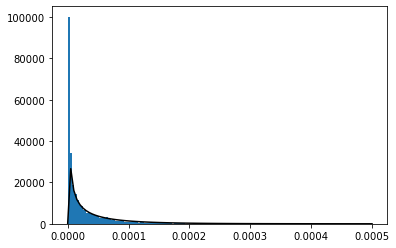

In [91]:
plt.hist(rainy_days, bins=100, density=True)
#xmin, xmax = plt.xlim()
    
x = np.linspace(0, 0.0005, 100)
p = scipy.stats.gamma.pdf(x, *fit_rainy_days)
    
plt.plot(x, p, 'k')

In [119]:
data2 = pr_obs[:, 1, 1]

rainy_days2 = data2[data2 != 0]

p02 = 1 - rainy_days2.shape[0] / data2.shape[0]

print('p0 = {}'.format(p02))

fit_rainy_days2 = scipy.stats.gamma.fit(rainy_days2, floc=0)

print('fit_rainy_days = {}'.format(fit_rainy_days2))

p0 = 0.29933333333333334
fit_rainy_days = (0.5588655515054326, 0, 4.967629397192224e-05)


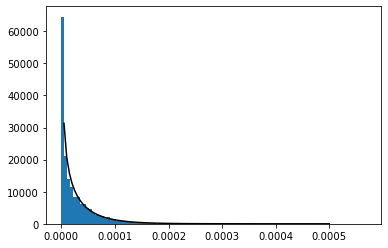

In [120]:
plt.hist(rainy_days2, bins=100, density=True)
    
x = np.linspace(0, 0.0005, 100)
p = scipy.stats.gamma.pdf(x, *fit_rainy_days2)
    
plt.plot(x, p, 'k')

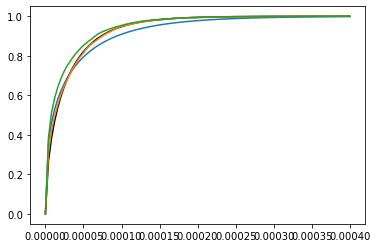

In [123]:
from PACKAGE_NAME.utils import ecdf
x = np.linspace(0, 0.0004, 100)
p1 = scipy.stats.gamma.cdf(x, *fit_rainy_days)
p2 = scipy.stats.gamma.cdf(x, *fit_rainy_days2)
p3 = ecdf(rainy_days2, x, method = "linear_interpolation")
p4 = ecdf(rainy_days, x, method = "linear_interpolation")
plt.plot(x, p1)
plt.plot(x, p2, 'k')
plt.plot(x, p3)
plt.plot(x, p4)